In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cma
import numba
import os
import math

C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Sofia\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
#params
##data
amp, centre, sigma = (0.6969641043116005, 1.4904524578404597, 1.3102271681828053)

x_data = [0, 3, 6, 10, 20]

Aktp_data = [1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data = [1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data = [1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM = [0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM = [0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM = [0.0, 0.11, 0.21, 0.18, 0.17]

x_data2 = [-60, -30, -5, 0, 3, 6, 10, 20]

Aktp_data2 = [1, 1, 1, 1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data2 = [1, 1, 1, 1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data2 = [1, 1, 1, 1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM2 = [0.32, 0.32, 0.32, 0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM2 = [0.32, 0.32, 0.32, 0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM2 = [0.36, 0.36, 0.36, 0.0, 0.11, 0.21, 0.18, 0.17]

data = np.array([[Aktp_data], [Agop_data], [Agopgw_data]])
data_sem = np.array([[Aktp_data_SEM], [Agop_data_SEM], [Agopgw_data_SEM]])

data2 = np.array([[Aktp_data2], [Agop_data2], [Agopgw_data2]])
data_sem2 = np.array([[Aktp_data_SEM2], [Agop_data_SEM2], [Agopgw_data_SEM2]])

nmda_x = [108.77762801045833-120, 125.66705100930517-120, 147.06140279649867-120, 168.61165694983492-120, 188.7003264205789-120, 208.8734430063173-120, 224.78198028484644-120, 252.21430079412767-120, 266.70672491352275-120, 292.67421277425-120, 308.54702242720464-120, 327.3170177176539-120, 350.40031180473215-120, 369.15731523133604-120,]
nmda_y = [0.2911963882618509, 0.5530474040632054, 0.6839729119638827, 0.7065462753950338, 0.7449209932279908, 0.7246049661399547, 0.6681715575620766, 0.6027088036117381, 0.5304740406320541, 0.4830699774266365, 0.4514672686230248, 0.4063205417607221, 0.3634311512415347, 0.3273137697516928,]
nmda_sem = [0.3702031602708802, 0.6817155756207673, 0.8600451467268622, 0.8893905191873588, 0.9638826185101579, 0.9480812641083518, 0.8781038374717831, 0.8239277652370203, 0.7223476297968396, 0.6681715575620766, 0.6094808126410833, 0.5643340857787809, 0.5079006772009027, 0.46275395033860045]
nmda_sem = np.array(nmda_sem) - np.array(nmda_y)
nmda_x = np.array(nmda_x) / 60

nmda_y = np.array(nmda_y)

#diffusion coefficients, sc = cytosol sm = membrane
sc1 = 14.e-2 #/10 #14 #Akt and Aktp
sc2 = 12.e-2 #/10 #12 #Ago and Agop
sc3 = 9.0e-2 #/10 #9 #GW
sc4 = 8.0e-2 #/10 #8 #Agopgw

diffs = [sc1, sc2, sc3, sc4]

##geometry
#neck
length_neck = 0.8
radius_neck = 0.07
circumference_neck = 2 * math.pi * radius_neck
area_neck = circumference_neck * length_neck 

#dendrite
radius_dendrite = 0.22
length_dendrite = 1.2 #*10
circumference_dendrite = 2 * math.pi * radius_dendrite
volume_dendrite = (radius_dendrite**2) * math.pi * length_dendrite

#head
radius_head = 0.18
volume_head = (radius_head**3) * math.pi * (4/3)

space1 = area_neck / (volume_dendrite * length_neck)
space2 = (area_neck / (volume_head * length_neck))#/1.5

##others
dt = 0.01
minutes = 20
numtimesteps = minutes/dt #100

#rate constants
k1, k_1, k2, k_2, k3, k_3, Akt_init, Aktp_init, \
Ago_init, Agop_init, Gw_init, Agopgw_init = np.log(np.array([0.1120165537522212, 0.08686945369849815, \
                                                            2.9496545905557634e-11, 1.3630288182352532, \
                                                            0.003824782763032001, 0.5890498603252491, \
                                                            0.0004142640604934913, 4.84682761129824e-05, \
                                                            8407.438562213689, 6.823592910564847e-12, \
                                                            1.470134093011058e-09, 6.837034204841468e-23]))

rates = [k1, k_1, k2, k_2, k3, k_3]*2
inits = [Akt_init, Aktp_init,  Ago_init, Agop_init, Gw_init, Agopgw_init]

theta = np.array(rates + inits)

beg = 0
beg2 = -10

cs = 1
cd = 1

In [3]:
#first simple model function

#@numba.jit()
def model2(theta, diffs, cs = 1, cd = 1, **kwargs):
    
    def gauss(x, amp, centre, sigma):
        return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 
    
    sk1, sk_1, sk2, sk_2, sk3, sk_3,  dk1, dk_1, dk2, dk_2, dk3, dk_3, Akt0, Aktp0, Ago0, Agop0, Gw0, Agopgw0 = np.exp(theta)

    sc1, sc2, sc3, sc4 = diffs
    
    for key in kwargs:
        exec(f'{key} = {kwargs[key]}')
    
    dAkt = np.zeros(int((minutes - beg)/dt))
    sAkt = np.zeros(int((minutes - beg)/dt))
    dAktp = np.zeros(int((minutes - beg)/dt))
    sAktp = np.zeros(int((minutes - beg)/dt))
    dAgo = np.zeros(int((minutes - beg)/dt))
    sAgo = np.zeros(int((minutes - beg)/dt))
    dAgop = np.zeros(int((minutes - beg)/dt))
    sAgop = np.zeros(int((minutes - beg)/dt))
    dGw = np.zeros(int((minutes - beg)/dt))
    sGw = np.zeros(int((minutes - beg)/dt))
    dAgopgw = np.zeros(int((minutes - beg)/dt))
    sAgopgw = np.zeros(int((minutes - beg)/dt))
    time = np.linspace(int(beg), int(minutes), int((minutes-beg)/dt))
    
    NMDA = gauss(time, amp, centre, sigma)
    
    dAkt[0] = Akt0
    sAkt[0] = Akt0
    dAktp[0] = Aktp0
    sAktp[0] = Aktp0
    dAgo[0] = Ago0
    sAgo[0] = Ago0
    dAgop[0] = Agop0
    sAgop[0] = Agop0
    dGw[0] = Gw0
    sGw[0] = Gw0
    dAgopgw[0] = Agopgw0
    sAgopgw[0] = Agopgw0
    
    for i in range(1, int((minutes-beg)/dt)):
        dAkt[i] = dAkt[i-1] + dt*(sc1*space1*(sAkt[i-1] - dAkt[i-1]) + (dAktp[i-1]*dk_1 - dAkt[i-1]*dk1*cd*NMDA[i]))
        sAkt[i] = sAkt[i-1] + dt*(sc1*space2*(dAkt[i-1] - sAkt[i-1]) + (sAktp[i-1]*sk_1 - sAkt[i-1]*sk1*cs*NMDA[i]))
        
        dAktp[i] = dAktp[i-1] + dt*(sc1*space1*(sAkt[i-1] - dAkt[i-1]) + (dAkt[i-1]*dk1*cd*NMDA[i] - dAktp[i-1]*dk_1))
        sAktp[i] = sAktp[i-1] + dt*(sc1*space2*(dAkt[i-1] - sAkt[i-1]) + (sAkt[i-1]*sk1*cs*NMDA[i] - sAktp[i-1]*sk_1))
        
        dAgo[i] = dAgo[i-1] + dt*(sc2*space1*(sAkt[i-1] - dAkt[i-1]) + (dAgop[i-1]*dk_2 - dAktp[i-1]*dAgo[i-1]*dk2))
        sAgo[i] = sAgo[i-1] + dt*(sc2*space2*(dAkt[i-1] - sAkt[i-1]) + (sAgop[i-1]*sk_2 - sAktp[i-1]*sAgo[i-1]*sk2))
        
        dAgop[i] = dAgop[i-1] + dt*(sc2*space1*(sAkt[i-1] - dAkt[i-1]) + (dAktp[i-1]*dAgo[i-1]*dk2 + dAgopgw[i-1]*dk_3 - dAgop[i-1]*dk_2 - dAgop[i-1]*dGw[i-1]*dk3))
        sAgop[i] = sAgop[i-1] + dt*(sc2*space2*(dAkt[i-1] - sAkt[i-1]) + (sAktp[i-1]*sAgo[i-1]*sk2 + sAgopgw[i-1]*sk_3 - sAgop[i-1]*sk_2 - sAgop[i-1]*sGw[i-1]*sk3))
        
        dGw[i] = dGw[i-1] + dt*(sc3*space1*(sGw[i-1] - dGw[i-1]) + (dAgopgw[i-1]*dk_3 - dAgop[i-1]*dGw[i-1]*dk3))
        sGw[i] = sGw[i-1] + dt*(sc3*space2*(dGw[i-1] - sGw[i-1]) + (sAgopgw[i-1]*sk_3 - sAgop[i-1]*sGw[i-1]*sk3))
        
        dAgopgw[i] = dAgopgw[i-1] + dt*(sc4*space1*(sAgopgw[i-1] - dAgopgw[i-1]) + (dAgop[i-1]*dGw[i-1]*dk3 - dAgopgw[i-1]*dk_3))
        sAgopgw[i] = sAgopgw[i-1] + dt*(sc4*space2*(dAgopgw[i-1] - sAgopgw[i-1]) + (sAgop[i-1]*sGw[i-1]*sk3 - sAgopgw[i-1]*sk_3))
        
    return sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time

In [4]:
#first simple model function fc calculation
def foldChange1(theta, diffs, cs = 1, cd = 1, **kwargs):
    sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, diffs, cs = cs, cd = cd, **kwargs)

    Akt = sAkt + dAkt
    Aktp = sAktp + dAktp
    Ago = sAgo + dAgo
    Agop = sAgop + dAgop
    Gw = sGw + dGw
    Agopgw = sAgopgw + dAgopgw
    
    Aktp_fold = np.zeros(len(Akt))
    Agop_fold = np.zeros(len(Akt))
    Agopgw_fold = np.zeros(len(Akt))
    
    for i in range(len(Akt)):
            Aktp_fold[i] = Aktp[i] / ( Aktp[0] )#+ Akt[0]) / akcont
            Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
            Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont
            
    return Aktp_fold, Agop_fold, Agopgw_fold, time 

In [5]:
#first simple model function fc calculation
def foldChange2(theta, diffs, cs = 1, cd = 1, **kwargs):
    sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, diffs, cs = cs, cd = cd, **kwargs)
    
    sAktp_fold = np.zeros(len(sAkt))
    dAktp_fold = np.zeros(len(sAkt))
    
    sAgop_fold = np.zeros(len(sAkt))
    dAgop_fold = np.zeros(len(sAkt))
    
    sAgopgw_fold = np.zeros(len(sAkt))
    dAgopgw_fold = np.zeros(len(sAkt))

    for i in range(len(sAkt)):
        sAktp_fold[i] = sAktp[i] / ( sAktp[0] )#+ Akt[0]) / akcont
        dAktp_fold[i] = dAktp[i] / ( dAktp[0] )#+ Akt[0]) / akcont

        sAgop_fold[i] = (sAgop[i] + sAgopgw[i]) / ( sAgop[0]  + sAgopgw[0] )#+ Ago[0] ) / agcont
        dAgop_fold[i] = (dAgop[i] + dAgopgw[i]) / ( dAgop[0]  + dAgopgw[0] )#+ Ago[0] ) / agcont

        sAgopgw_fold[i] = sAgopgw[i] / ( sAgopgw[0] )#+ Gw[0]) / gwcont
        dAgopgw_fold[i] = dAgopgw[i] / ( dAgopgw[0] )#+ Gw[0]) / gwcont

            
    return sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time 

In [47]:
sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, diffs = diffs)

In [48]:
sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, diffs = diffs)

In [49]:
sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time = foldChange2(theta, diffs = diffs)

In [50]:
Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta, diffs)

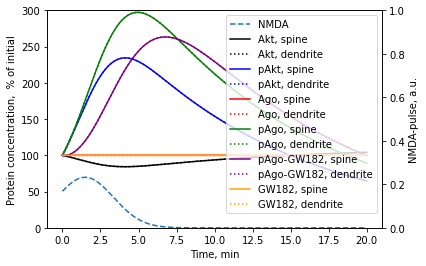

In [51]:
fig, ax = plt.subplots()

ax.plot(time,
        NMDA*100,
        color = 'C0',
        linestyle = '--')
ax.plot(time,
        sAkt/(sAkt[0])*100,
        color = 'black',
        linestyle = '-')
ax.plot(time,
        dAkt/(dAkt[0])*100,
        color = 'black',
        linestyle = ':')
ax.plot(time,
        sAktp/(sAktp[0])*100,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp/(dAktp[0])*100,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgo/(sAgo[0])*100,
        color = 'red',
        linestyle = '-')
ax.plot(time,
        dAgo/(dAgo[0])*100,
        color = 'red',
        linestyle = ':')
ax.plot(time,
        sAgop/(sAgop[0])*100,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop/(dAgop[0])*100,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw/(sAgopgw[0])*100,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw/(dAgopgw[0])*100,
        color = 'purple',
        linestyle = ':')
ax.plot(time,
        sGw/(sGw[0])*100,
        color = 'orange',
        linestyle = '-')
ax.plot(time,
        dGw/(dGw[0])*100,
        color = 'orange',
        linestyle = ':')

ax.set_ylim(0, 300)

l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')

ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]

ax.set_ylabel('Protein concentration,  % of initial')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)

#nmda stimulation happens globally
plt.savefig(r'./plots/dual-comparment_global-nmda_protein-concs-time.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

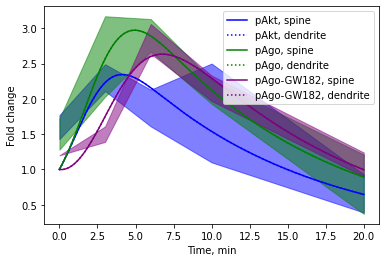

In [52]:
fig, ax = plt.subplots()

ax.plot(time,
        sAktp_fold,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp_fold,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgop_fold,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop_fold,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw_fold,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw_fold,
        color = 'purple',
        linestyle = ':')

ax.fill_between(x_data,
                np.array(Aktp_data) - np.array(Aktp_data_SEM),
                np.array(Aktp_data) + np.array(Aktp_data_SEM),
                color = 'blue',
                alpha =  0.5)
ax.fill_between(x_data,
                np.array(Agop_data) - np.array(Agop_data_SEM),
                np.array(Agop_data) + np.array(Agop_data_SEM),
                color = 'green',
                alpha =  0.5)
ax.fill_between(x_data,
                np.array(Agopgw_data) - np.array(Agopgw_data_SEM),
                np.array(Agopgw_data) + np.array(Agopgw_data_SEM),
                color = 'purple',
                alpha =  0.5)

l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')

ls = [l2, l2d, l4, l4d, l5, l5d]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

#ax2 = ax.twinx()
#ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)

plt.savefig(r'./plots/fc_global-nmda_comparments.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

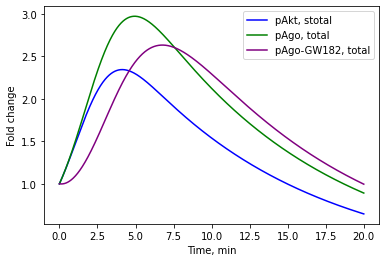

In [53]:
fig, ax = plt.subplots()

ax.plot(time,
        Aktp_fold,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        Agop_fold,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        Agopgw_fold,
        color = 'purple',
        linestyle = '-')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, stotal')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, total')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, total')

ls = [l2, l4, l5,]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

#ax2 = ax.twinx()
#ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)



plt.show()

In [6]:
sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, diffs, cd = 0)

In [7]:
sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time = foldChange2(theta, diffs, cd = 0)

In [8]:
Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta, diffs, cd = 0)

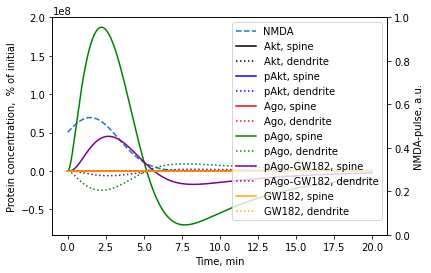

In [14]:
fig, ax = plt.subplots()

ax.plot(time,
        NMDA*100*1e6,
        color = 'C0',
        linestyle = '--')
ax.plot(time,
        sAkt/(sAkt[0])*100,
        color = 'black',
        linestyle = '-')
ax.plot(time,
        dAkt/(dAkt[0])*100,
        color = 'black',
        linestyle = ':')
ax.plot(time,
        sAktp/(sAktp[0])*100,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp/(dAktp[0])*100,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgo/(sAgo[0])*100,
        color = 'red',
        linestyle = '-')
ax.plot(time,
        dAgo/(dAgo[0])*100,
        color = 'red',
        linestyle = ':')
ax.plot(time,
        sAgop/(sAgop[0])*100,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop/(dAgop[0])*100,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw/(sAgopgw[0])*100,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw/(dAgopgw[0])*100,
        color = 'purple',
        linestyle = ':')
ax.plot(time,
        sGw/(sGw[0])*100,
        color = 'orange',
        linestyle = '-')
ax.plot(time,
        dGw/(dGw[0])*100,
        color = 'orange',
        linestyle = ':')

#ax.set_ylim(0, 300)
#ax.set_yscale('log')

l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')

ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]

ax.set_ylabel('Protein concentration,  % of initial')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)

#nmda stimulation happens globally
#plt.savefig(r'./plots/dual-comparment_spine-nmda_protein-concs-time.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

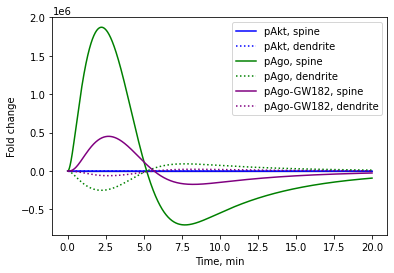

In [58]:
fig, ax = plt.subplots()

ax.plot(time,
        sAktp_fold,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp_fold,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgop_fold,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop_fold,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw_fold,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw_fold,
        color = 'purple',
        linestyle = ':')

ax.fill_between(x_data,
                np.array(Aktp_data) - np.array(Aktp_data_SEM),
                np.array(Aktp_data) + np.array(Aktp_data_SEM),
                color = 'blue',
                alpha =  0.5)
ax.fill_between(x_data,
                np.array(Agop_data) - np.array(Agop_data_SEM),
                np.array(Agop_data) + np.array(Agop_data_SEM),
                color = 'green',
                alpha =  0.5)
ax.fill_between(x_data,
                np.array(Agopgw_data) - np.array(Agopgw_data_SEM),
                np.array(Agopgw_data) + np.array(Agopgw_data_SEM),
                color = 'purple',
                alpha =  0.5)

l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')

ls = [l2, l2d, l4, l4d, l5, l5d]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

#ax2 = ax.twinx()
#ax2.set_ylabel('NMDA-pulse, a.u.')
#ax.set_yscale('log')

plt.legend(handles = ls, loc = 1)

plt.savefig(r'./plots/fc_spine-nmda_comparments.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

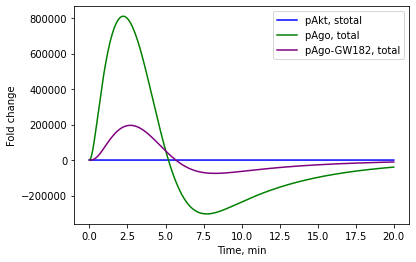

In [18]:
fig, ax = plt.subplots()

ax.plot(time,
        Aktp_fold,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        Agop_fold,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        Agopgw_fold,
        color = 'purple',
        linestyle = '-')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, stotal')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, total')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, total')

ls = [l2, l4, l5,]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

#ax2 = ax.twinx()
#ax2.set_ylabel('NMDA-pulse, a.u.')
#
plt.legend(handles = ls, loc = 1)



plt.show()

In [19]:
def createCoordinates(xx, yy):
    coords = []
    for i in range(xx):
        for j in range(yy):
            coords.append((i, j))
    return coords

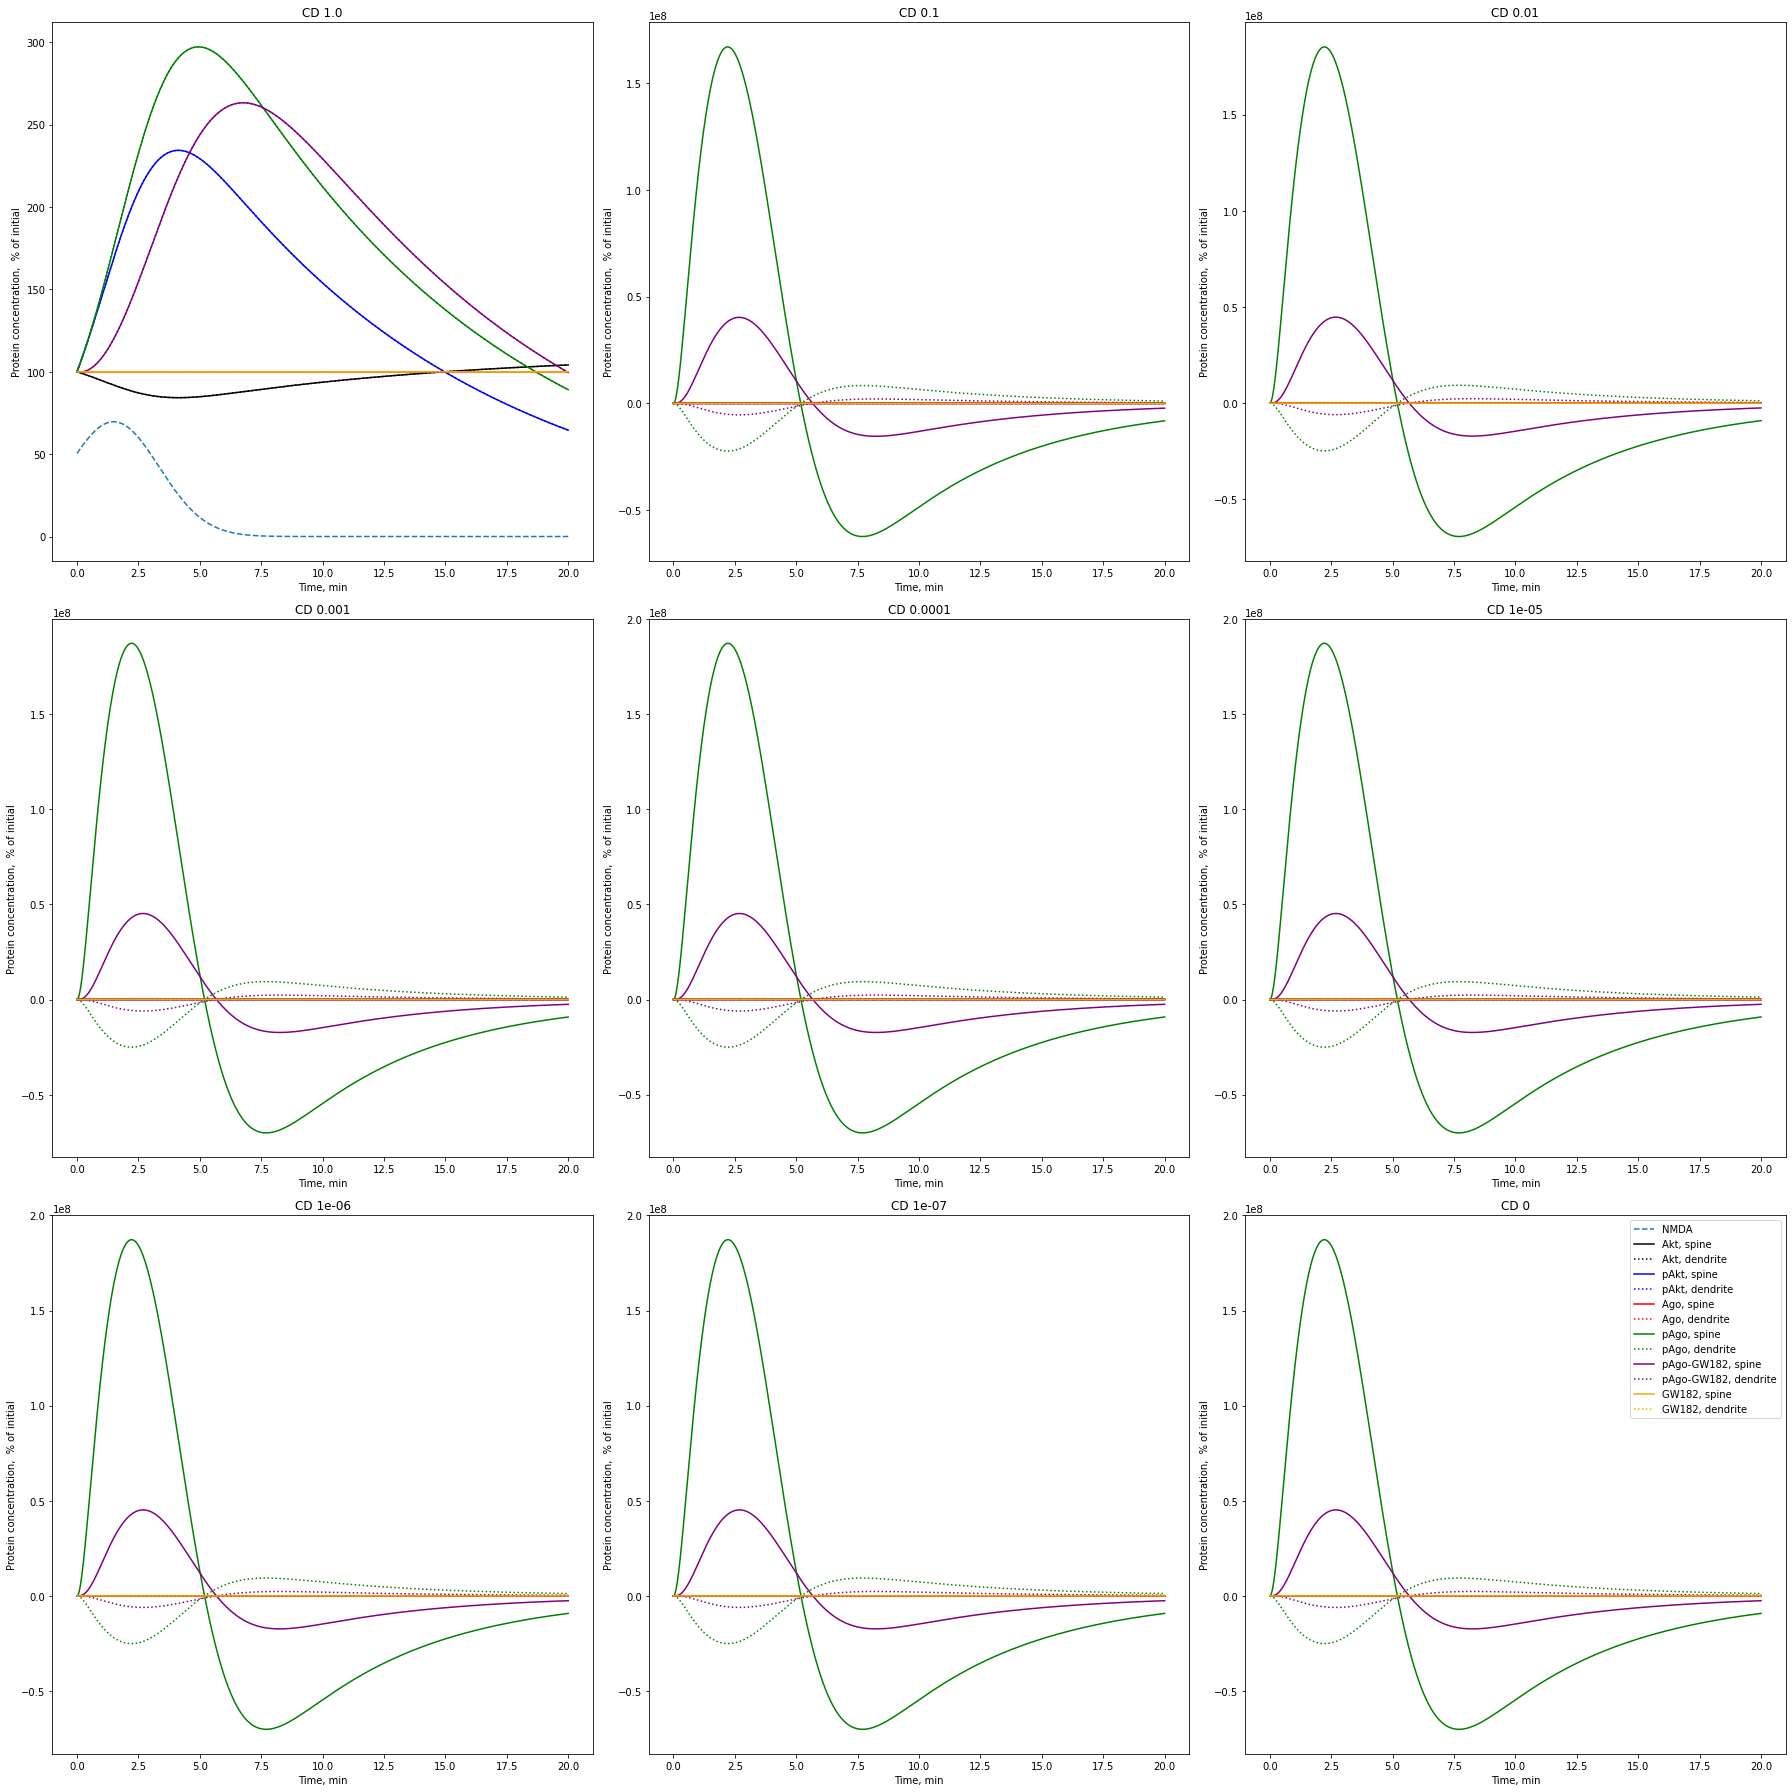

In [61]:
cds = [10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 0]
coords = createCoordinates(3,3)

fig, ax = plt.subplots(3,3, figsize = (25,25))
for i in range(len(cds)):

    sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, diffs, cd = cds[i])
    
    
    ax[coords[i]].plot(time,
            NMDA*100,
            color = 'C0',
            linestyle = '--')
    ax[coords[i]].plot(time,
            sAkt/(sAkt[0])*100,
            color = 'black',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAkt/(dAkt[0])*100,
            color = 'black',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAktp/(sAktp[0])*100,
            color = 'blue',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAktp/(dAktp[0])*100,
            color = 'blue',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgo/(sAgo[0])*100,
            color = 'red',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgo/(dAgo[0])*100,
            color = 'red',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgop/(sAgop[0])*100,
            color = 'green',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgop/(dAgop[0])*100,
            color = 'green',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgopgw/(sAgopgw[0])*100,
            color = 'purple',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgopgw/(dAgopgw[0])*100,
            color = 'purple',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sGw/(sGw[0])*100,
            color = 'orange',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dGw/(dGw[0])*100,
            color = 'orange',
            linestyle = ':')
    
    #ax[coords[i]].set_ylim(0, 300)

    ax[coords[i]].set_ylabel('Protein concentration,  % of initial')
    ax[coords[i]].set_xlabel('Time, min')

    ax[coords[i]].set_title(f'CD {cds[i]}')
    
l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')
    
ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]
    
    
    
plt.legend(handles = ls, loc = 1)
    
    #nmda stimulation happens globally

fig.tight_layout()
plt.savefig(r'./plots/dual-comparment_different-nmdas_protein-concs-time.svg', dpi = 600, bbox_inches = 'tight')
    
plt.show()

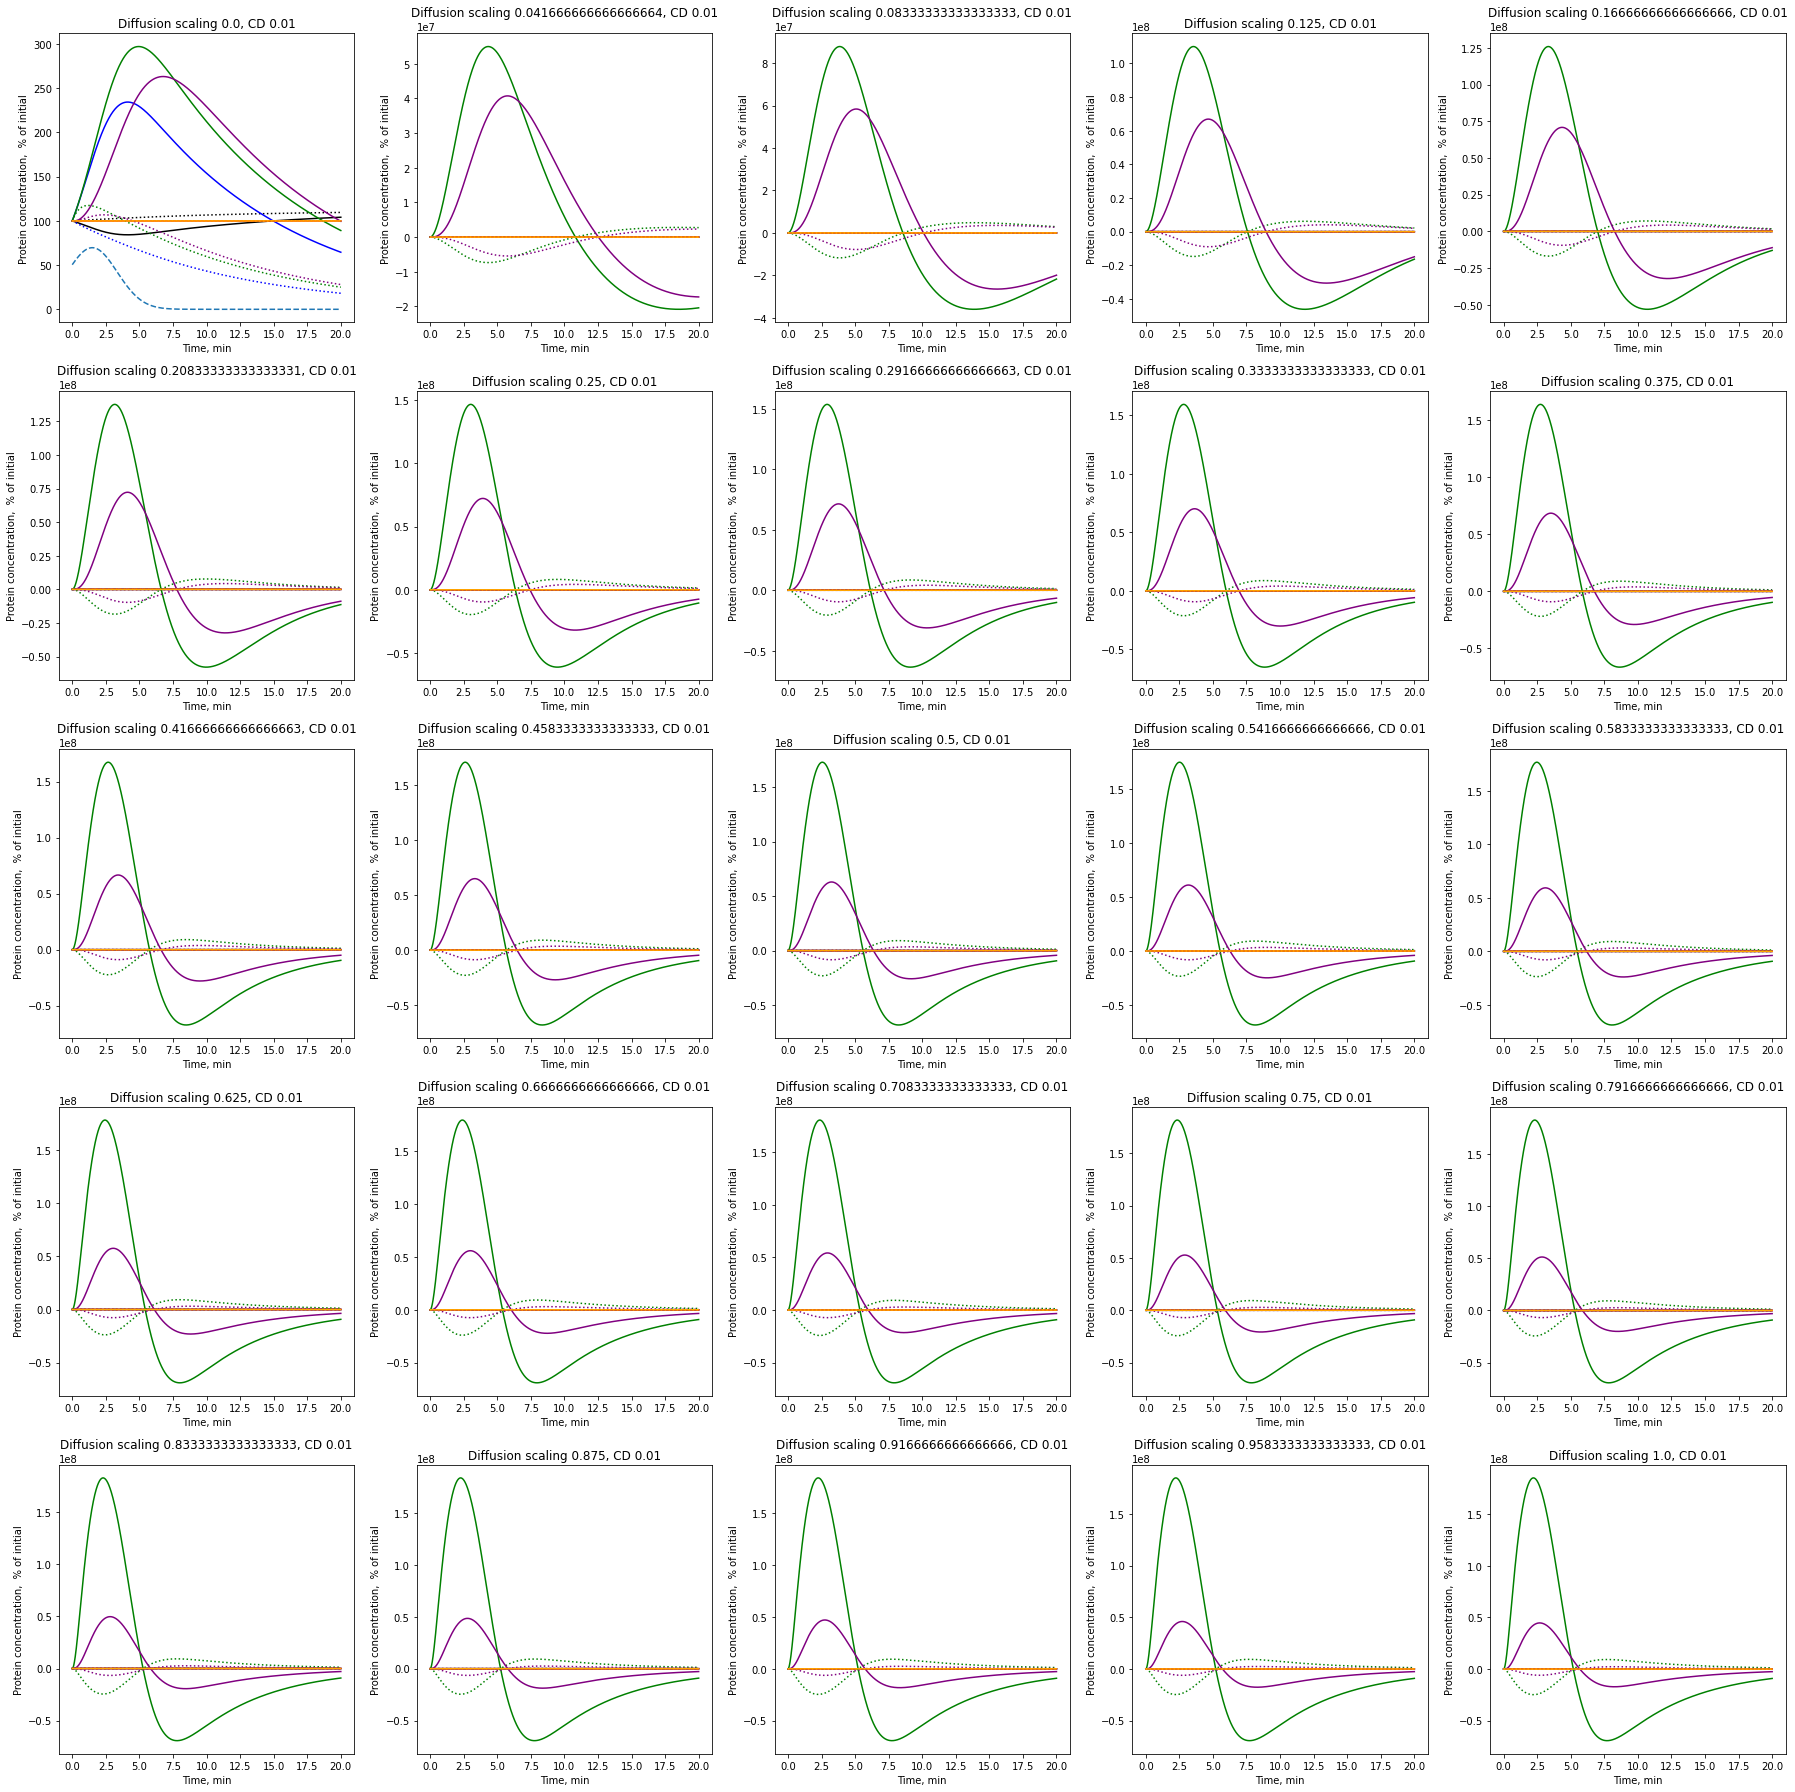

In [21]:
scaling = np.linspace(0, 1, 25)
coords = createCoordinates(5,5)

fig, ax = plt.subplots(5,5, figsize = (25,25))
for i in range(len(scaling)):

    sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, [k*scaling[i] for k in diffs], cd = .01)
    
    
    ax[coords[i]].plot(time,
            NMDA*100,
            color = 'C0',
            linestyle = '--')
    ax[coords[i]].plot(time,
            sAkt/(sAkt[0])*100,
            color = 'black',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAkt/(dAkt[0])*100,
            color = 'black',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAktp/(sAktp[0])*100,
            color = 'blue',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAktp/(dAktp[0])*100,
            color = 'blue',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgo/(sAgo[0])*100,
            color = 'red',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgo/(dAgo[0])*100,
            color = 'red',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgop/(sAgop[0])*100,
            color = 'green',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgop/(dAgop[0])*100,
            color = 'green',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgopgw/(sAgopgw[0])*100,
            color = 'purple',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgopgw/(dAgopgw[0])*100,
            color = 'purple',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sGw/(sGw[0])*100,
            color = 'orange',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dGw/(dGw[0])*100,
            color = 'orange',
            linestyle = ':')
    
    #ax[coords[i]].set_ylim(0, 300)

    ax[coords[i]].set_ylabel('Protein concentration,  % of initial')
    ax[coords[i]].set_xlabel('Time, min')

    ax[coords[i]].set_title(f'Diffusion scaling {scaling[i]}, CD 0.01')
    
l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')
    
ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]
    
    
    
#plt.legend(handles = ls, loc = 1)
    
    #nmda stimulation happens globally

fig.tight_layout()
#plt.savefig(r'./plots/dual-comparment_different-diffusions_low-cd_protein-concs-time.svg', dpi = 600, bbox_inches = 'tight')
    
plt.show()

In [22]:
sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time = foldChange2(theta, [0,0,0,0], cd = 0)

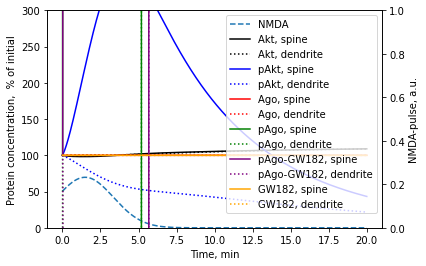

In [23]:
fig, ax = plt.subplots()

ax.plot(time,
        NMDA*100,
        color = 'C0',
        linestyle = '--')
ax.plot(time,
        sAkt/(sAkt[0])*100,
        color = 'black',
        linestyle = '-')
ax.plot(time,
        dAkt/(dAkt[0])*100,
        color = 'black',
        linestyle = ':')
ax.plot(time,
        sAktp/(sAktp[0])*100,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp/(dAktp[0])*100,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgo/(sAgo[0])*100,
        color = 'red',
        linestyle = '-')
ax.plot(time,
        dAgo/(dAgo[0])*100,
        color = 'red',
        linestyle = ':')
ax.plot(time,
        sAgop/(sAgop[0])*100,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop/(dAgop[0])*100,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw/(sAgopgw[0])*100,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw/(dAgopgw[0])*100,
        color = 'purple',
        linestyle = ':')
ax.plot(time,
        sGw/(sGw[0])*100,
        color = 'orange',
        linestyle = '-')
ax.plot(time,
        dGw/(dGw[0])*100,
        color = 'orange',
        linestyle = ':')

ax.set_ylim(0, 300)

l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')

ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]

ax.set_ylabel('Protein concentration,  % of initial')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)

#nmda stimulation happens globally
#plt.savefig(r'./plots/dual-comparment_spine-nmda_protein-concs-time.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [24]:
Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta, [0, 0, 0, 0], cd = 1)

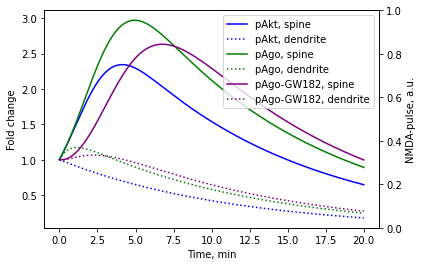

In [25]:
fig, ax = plt.subplots()

ax.plot(time,
        sAktp_fold,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp_fold,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgop_fold,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop_fold,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw_fold,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw_fold,
        color = 'purple',
        linestyle = ':')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')

ls = [l2, l2d, l4, l4d, l5, l5d]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)

#plt.savefig(r'./plots/fc_global-nmda_comparments.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

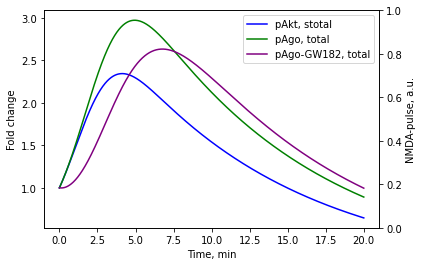

In [26]:
fig, ax = plt.subplots()

ax.plot(time,
        Aktp_fold,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        Agop_fold,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        Agopgw_fold,
        color = 'purple',
        linestyle = '-')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, stotal')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, total')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, total')

ls = [l2, l4, l5,]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)



plt.show()

In [27]:
10e-2

0.1

In [28]:
sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, [k*10e-7 for k in diffs], cd = .01)

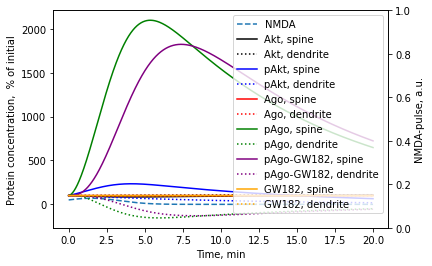

In [29]:
fig, ax = plt.subplots()

ax.plot(time,
        NMDA*100,
        color = 'C0',
        linestyle = '--')
ax.plot(time,
        sAkt/(sAkt[0])*100,
        color = 'black',
        linestyle = '-')
ax.plot(time,
        dAkt/(dAkt[0])*100,
        color = 'black',
        linestyle = ':')
ax.plot(time,
        sAktp/(sAktp[0])*100,
        color = 'blue',
        linestyle = '-')
ax.plot(time,
        dAktp/(dAktp[0])*100,
        color = 'blue',
        linestyle = ':')
ax.plot(time,
        sAgo/(sAgo[0])*100,
        color = 'red',
        linestyle = '-')
ax.plot(time,
        dAgo/(dAgo[0])*100,
        color = 'red',
        linestyle = ':')
ax.plot(time,
        sAgop/(sAgop[0])*100,
        color = 'green',
        linestyle = '-')
ax.plot(time,
        dAgop/(dAgop[0])*100,
        color = 'green',
        linestyle = ':')
ax.plot(time,
        sAgopgw/(sAgopgw[0])*100,
        color = 'purple',
        linestyle = '-')
ax.plot(time,
        dAgopgw/(dAgopgw[0])*100,
        color = 'purple',
        linestyle = ':')
ax.plot(time,
        sGw/(sGw[0])*100,
        color = 'orange',
        linestyle = '-')
ax.plot(time,
        dGw/(dGw[0])*100,
        color = 'orange',
        linestyle = ':')

#ax.set_ylim(0, 300)

l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')

ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]

ax.set_ylabel('Protein concentration,  % of initial')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

plt.legend(handles = ls, loc = 1)

#nmda stimulation happens globally
#plt.savefig(r'./plots/dual-comparment_spine-nmda_protein-concs-time.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

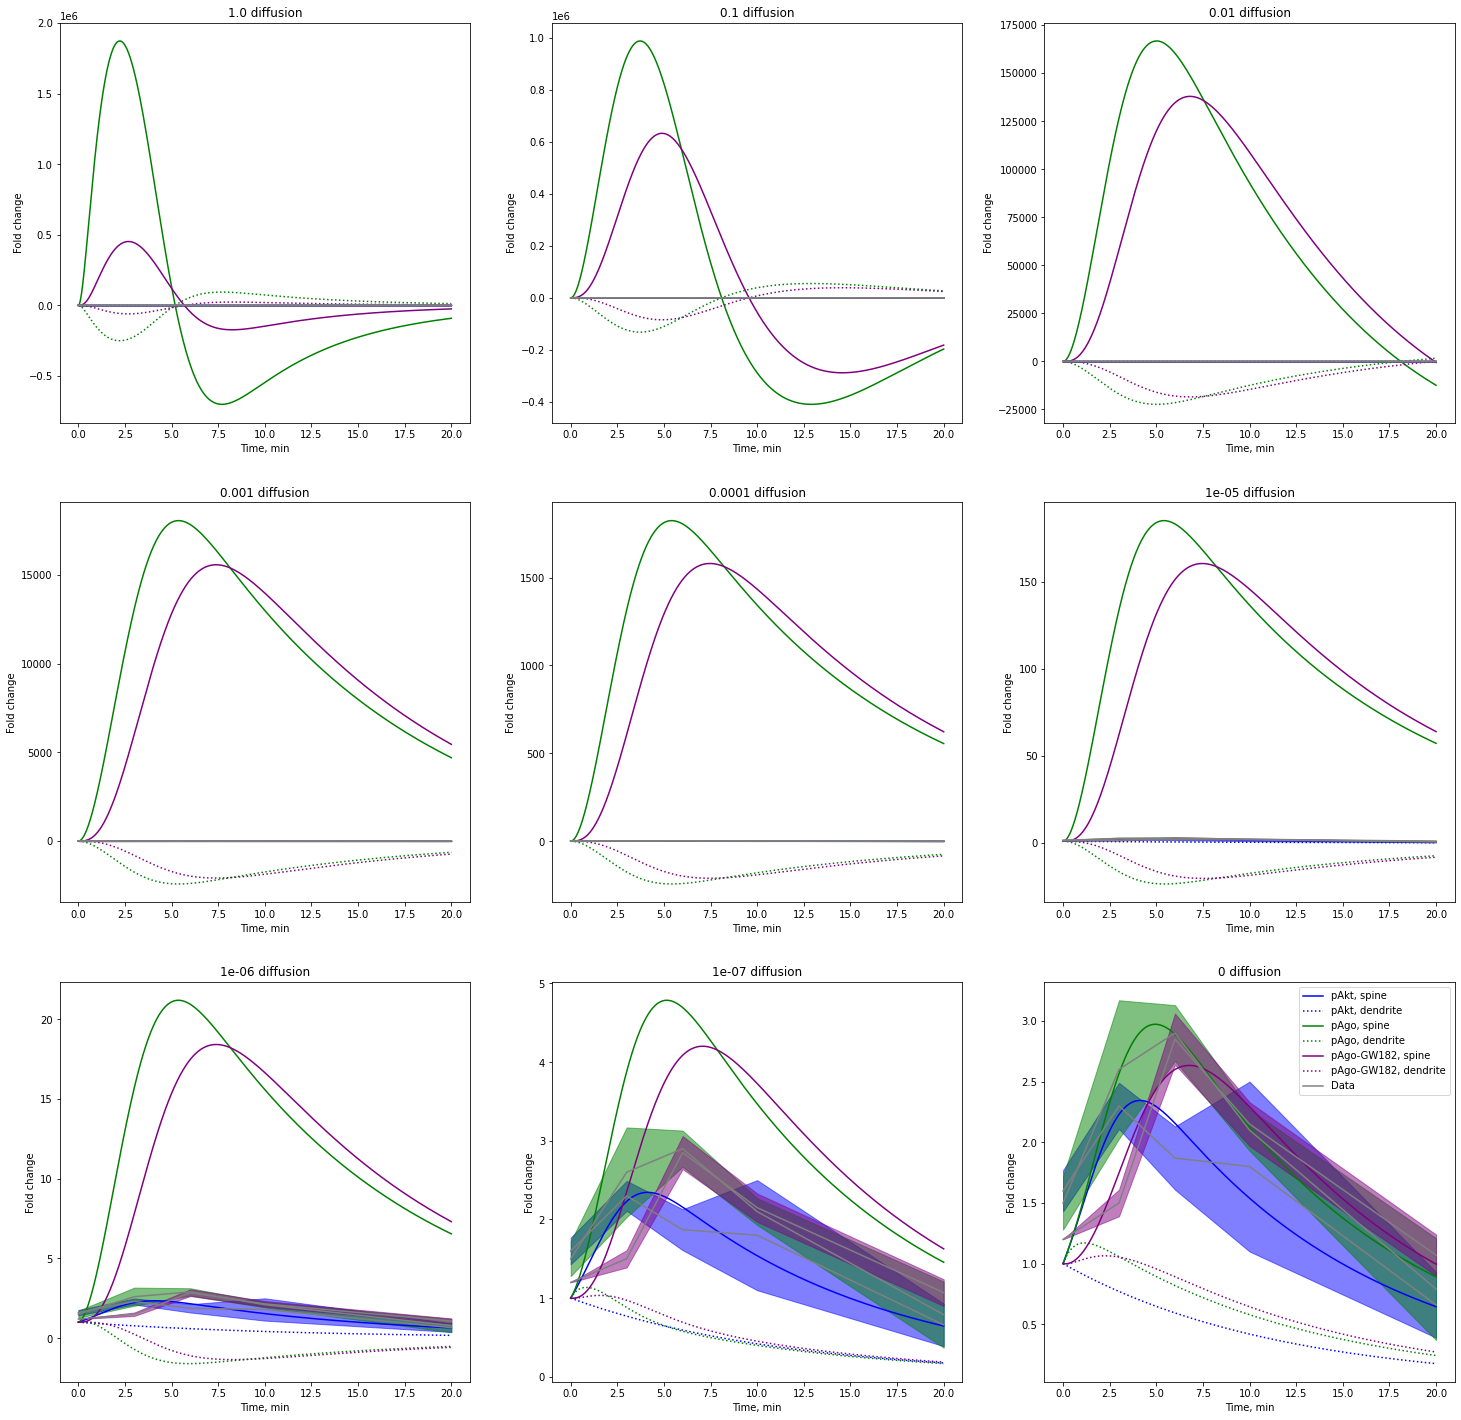

In [30]:
scaling = [10e-1, 10e-2, 10e-3, 10e-4, 10e-5, 10e-6, 10e-7, 10e-8, 0]
coords = createCoordinates(3,3)

fig, ax = plt.subplots(3,3, figsize = (25,25))
for i in range(len(scaling)):
    
    sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time = foldChange2(theta, [k*scaling[i] for k in diffs], cd = 0)

    ax[coords[i]].plot(time,
            sAktp_fold,
            color = 'blue',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAktp_fold,
            color = 'blue',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgop_fold,
            color = 'green',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgop_fold,
            color = 'green',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgopgw_fold,
            color = 'purple',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgopgw_fold,
            color = 'purple',
                linestyle = ':')
    ax[coords[i]].set_ylabel('Fold change')
    ax[coords[i]].set_xlabel('Time, min')
    ax[coords[i]].set_title(f'{scaling[i]} diffusion')
    
    ax[coords[i]].plot(x_data,
        Aktp_data,
        color = 'grey')
    ax[coords[i]].plot(x_data,
            Agop_data,
            color = 'grey')
    ax[coords[i]].plot(x_data,
            Agopgw_data,
            color = 'grey')


    ax[coords[i]].fill_between(x_data,
                np.array(Aktp_data) - np.array(Aktp_data_SEM),
                np.array(Aktp_data) + np.array(Aktp_data_SEM),
                color = 'blue',
                alpha =  0.5)
    ax[coords[i]].fill_between(x_data,
                    np.array(Agop_data) - np.array(Agop_data_SEM),
                    np.array(Agop_data) + np.array(Agop_data_SEM),
                    color = 'green',
                    alpha =  0.5)
    ax[coords[i]].fill_between(x_data,
                    np.array(Agopgw_data) - np.array(Agopgw_data_SEM),
                    np.array(Agopgw_data) + np.array(Agopgw_data_SEM),
                    color = 'purple',
                    alpha =  0.5)
    

l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 =  mlines.Line2D([], [], linestyle = '-', color = 'grey', label = 'Data')

ls = [l2, l2d, l4, l4d, l5, l5d, l6]



plt.legend(handles = ls, loc = 1)

plt.savefig(r'./plots/fc_spine_diffusion-scaled-with-data.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [31]:
aucs = {'spR': [],
        'dpR': [],
        'spA': [],
        'dpA': [],
        'spAG': [],
        'dpAG': []}
tenMin = {'spR': [],
        'dpR': [],
        'spA': [],
        'dpA': [],
        'spAG': [],
        'dpAG': []}
for i in range(len(scaling)):
    sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time = foldChange2(theta, [k*scaling[i] for k in diffs], cd = 0)
    
    aucs['spR'].append(scipy.integrate.simps(sAktp_fold))
    aucs['dpR'].append(scipy.integrate.simps(dAktp_fold))
    aucs['spA'].append(scipy.integrate.simps(sAgop_fold))
    aucs['dpA'].append(scipy.integrate.simps(dAgop_fold))
    aucs['spAG'].append(scipy.integrate.simps(sAgopgw_fold))
    aucs['dpAG'].append(scipy.integrate.simps(dAgopgw_fold))
    
    tenMin['spR'].append(np.interp(10, time, sAktp_fold))
    tenMin['dpR'].append(np.interp(10, time, dAktp_fold))
    tenMin['spA'].append(np.interp(10, time, sAgop_fold))
    tenMin['dpA'].append(np.interp(10, time, sAgop_fold))
    tenMin['spAG'].append(np.interp(10, time, sAgopgw_fold))
    tenMin['dpAG'].append(np.interp(10, time, sAgopgw_fold))

C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/3926758524.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['spR'].append(scipy.integrate.simps(sAktp_fold))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/3926758524.py:17: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['dpR'].append(scipy.integrate.simps(dAktp_fold))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/3926758524.py:18: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['spA'].append(scipy.integrate.simps(sAgop_fold))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/3926758524.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['dpA'].append(scipy.integ

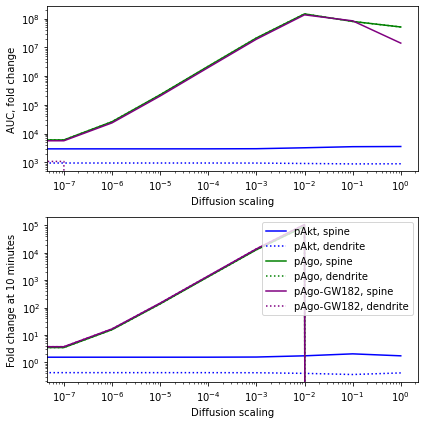

In [32]:
fig, ax = plt.subplots(2, figsize = (6, 6))

ax[0].plot(scaling,
           aucs['spR'],
           color = 'blue',
           linestyle = '-')
ax[0].plot(scaling,
           aucs['dpR'],
           color = 'blue',
           linestyle = ':')
ax[0].plot(scaling,
           aucs['spA'],
           color = 'green',
           linestyle = '-')
ax[0].plot(scaling,
           aucs['spA'],
           color = 'green',
           linestyle = ':')
ax[0].plot(scaling,
           aucs['spAG'],
           color = 'purple',
           linestyle = '-')
ax[0].plot(scaling,
           aucs['dpAG'],
           color = 'purple',
           linestyle = ':')

ax[0].set_ylabel('AUC, fold change')
ax[0].set_xlabel('Diffusion scaling')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].plot(scaling,
           tenMin['spR'],
           color = 'blue',
           linestyle = '-')
ax[1].plot(scaling,
           tenMin['dpR'],
           color = 'blue',
           linestyle = ':')
ax[1].plot(scaling,
           tenMin['spA'],
           color = 'green',
           linestyle = '-')
ax[1].plot(scaling,
           tenMin['spA'],
           color = 'green',
           linestyle = ':')
ax[1].plot(scaling,
           tenMin['spAG'],
           color = 'purple',
           linestyle = '-')
ax[1].plot(scaling,
           tenMin['dpAG'],
           color = 'purple',
           linestyle = ':')

ax[1].set_ylabel('Fold change at 10 minutes')
ax[1].set_xlabel('Diffusion scaling')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')

ls = [l2, l2d, l4, l4d, l5, l5d]



plt.legend(handles = ls, loc = 1)


plt.tight_layout()

plt.savefig(r'./plots/diffusion_scaling-vs-fold_change.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

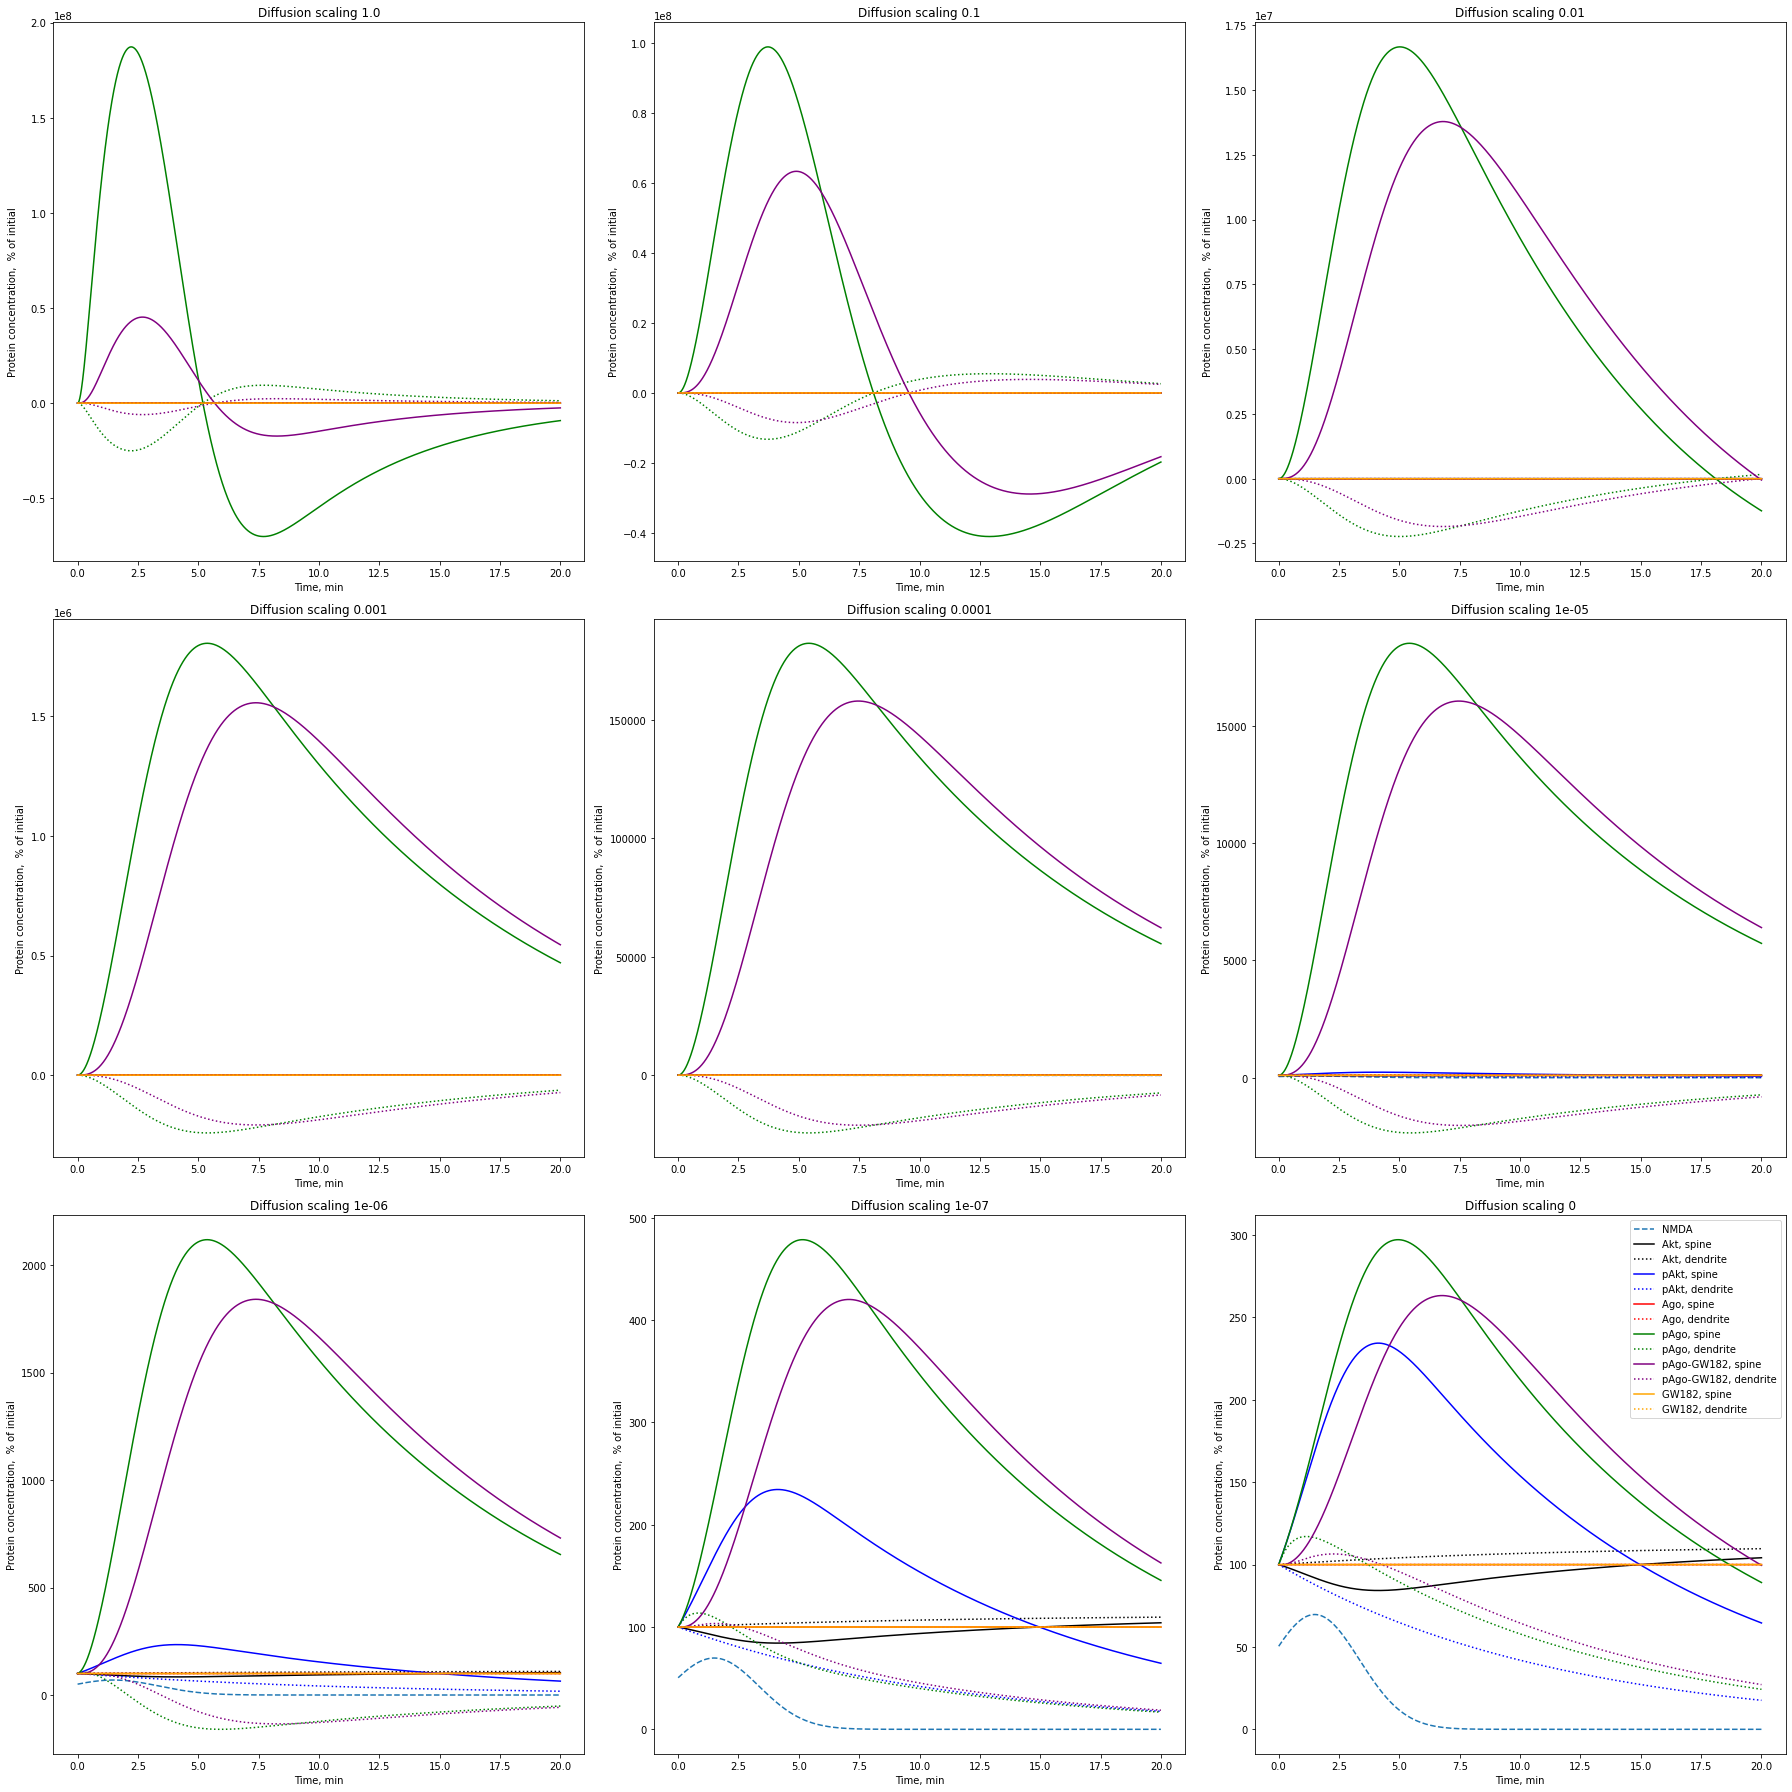

In [33]:
coords = createCoordinates(3,3)

fig, ax = plt.subplots(3,3, figsize = (25,25))
for i in range(len(scaling)):

    sAkt, sAktp, sAgo, sAgop, sGw, sAgopgw, dAkt, dAktp, dAgo, dAgop, dGw, dAgopgw, NMDA, time = model2(theta, [k*scaling[i] for k in diffs], cd = 0)
    
    
    ax[coords[i]].plot(time,
            NMDA*100,
            color = 'C0',
            linestyle = '--')
    ax[coords[i]].plot(time,
            sAkt/(sAkt[0])*100,
            color = 'black',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAkt/(dAkt[0])*100,
            color = 'black',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAktp/(sAktp[0])*100,
            color = 'blue',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAktp/(dAktp[0])*100,
            color = 'blue',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgo/(sAgo[0])*100,
            color = 'red',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgo/(dAgo[0])*100,
            color = 'red',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgop/(sAgop[0])*100,
            color = 'green',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgop/(dAgop[0])*100,
            color = 'green',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sAgopgw/(sAgopgw[0])*100,
            color = 'purple',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dAgopgw/(dAgopgw[0])*100,
            color = 'purple',
            linestyle = ':')
    ax[coords[i]].plot(time,
            sGw/(sGw[0])*100,
            color = 'orange',
            linestyle = '-')
    ax[coords[i]].plot(time,
            dGw/(dGw[0])*100,
            color = 'orange',
            linestyle = ':')
    
    #ax[coords[i]].set_ylim(0, 300)

    ax[coords[i]].set_ylabel('Protein concentration,  % of initial')
    ax[coords[i]].set_xlabel('Time, min')

    ax[coords[i]].set_title(f'Diffusion scaling {scaling[i]}')
    
l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt, spine')
l1d = mlines.Line2D([], [], linestyle = ':', color = 'black', label = 'Akt, dendrite')
l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l3 = mlines.Line2D([], [], linestyle = '-', color = 'red', label = 'Ago, spine')
l3d = mlines.Line2D([], [], linestyle = ':', color = 'red', label = 'Ago, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')
l6 = mlines.Line2D([], [], linestyle = '-', color = 'orange', label = 'GW182, spine')
l6d = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182, dendrite')
    
ls = [l0, l1, l1d, l2, l2d, l3, l3d, l4, l4d, l5, l5d, l6, l6d]
    
    
    
plt.legend(handles = ls, loc = 1)
    
fig.tight_layout()
plt.savefig(r'./plots/protein_change-spine_only-scaled-diffs.svg', dpi = 600, bbox_inches = 'tight')
    
plt.show()

In [34]:
Aktp_data = [1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data = [1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data = [1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM = [0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM = [0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM = [0.0, 0.11, 0.21, 0.18, 0.17]

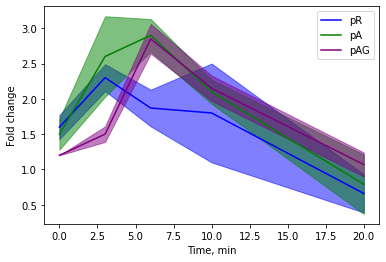

In [35]:
fig, ax = plt.subplots()

ax.plot(x_data,
        Aktp_data,
        color = 'blue')
ax.plot(x_data,
        Agop_data,
        color = 'green')
ax.plot(x_data,
        Agopgw_data,
        color = 'purple')

ax.fill_between(x_data,
                np.array(Aktp_data) - np.array(Aktp_data_SEM),
                np.array(Aktp_data) + np.array(Aktp_data_SEM),
                color = 'blue',
                alpha =  0.5)
ax.fill_between(x_data,
                np.array(Agop_data) - np.array(Agop_data_SEM),
                np.array(Agop_data) + np.array(Agop_data_SEM),
                color = 'green',
                alpha =  0.5)
ax.fill_between(x_data,
                np.array(Agopgw_data) - np.array(Agopgw_data_SEM),
                np.array(Agopgw_data) + np.array(Agopgw_data_SEM),
                color = 'purple',
                alpha =  0.5)

leg = [mlines.Line2D([], [], color = 'blue', label = 'pR'),
       mlines.Line2D([], [], color = 'green', label = 'pA'),
       mlines.Line2D([], [], color = 'purple', label = 'pAG')]

ax.set_ylabel('Fold change')
ax.set_xlabel('Time, min')

plt.legend(handles = leg, loc = 1)

plt.savefig(r'./plots/FCs-data.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [59]:
aucs = {'spR': [],
        'dpR': [],
        'spA': [],
        'dpA': [],
        'spAG': [],
        'dpAG': []}
tenMin = {'spR': [],
        'dpR': [],
        'spA': [],
        'dpA': [],
        'spAG': [],
        'dpAG': []}
for i in range(len(scaling)):
    sAktp_fold, sAgop_fold, sAgopgw_fold, dAktp_fold, dAgop_fold, dAgopgw_fold, time = foldChange2(theta, diffs, cd = scaling[i])
    
    aucs['spR'].append(scipy.integrate.simps(sAktp_fold))
    aucs['dpR'].append(scipy.integrate.simps(dAktp_fold))
    aucs['spA'].append(scipy.integrate.simps(sAgop_fold))
    aucs['dpA'].append(scipy.integrate.simps(dAgop_fold))
    aucs['spAG'].append(scipy.integrate.simps(sAgopgw_fold))
    aucs['dpAG'].append(scipy.integrate.simps(dAgopgw_fold))
    
    tenMin['spR'].append(np.interp(10, time, sAktp_fold))
    tenMin['dpR'].append(np.interp(10, time, dAktp_fold))
    tenMin['spA'].append(np.interp(10, time, sAgop_fold))
    tenMin['dpA'].append(np.interp(10, time, sAgop_fold))
    tenMin['spAG'].append(np.interp(10, time, sAgopgw_fold))
    tenMin['dpAG'].append(np.interp(10, time, sAgopgw_fold))

C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/1853079046.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['spR'].append(scipy.integrate.simps(sAktp_fold))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/1853079046.py:17: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['dpR'].append(scipy.integrate.simps(dAktp_fold))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/1853079046.py:18: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['spA'].append(scipy.integrate.simps(sAgop_fold))
C:\Users\Sofia\AppData\Local\Temp/ipykernel_9932/1853079046.py:19: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  aucs['dpA'].append(scipy.integ

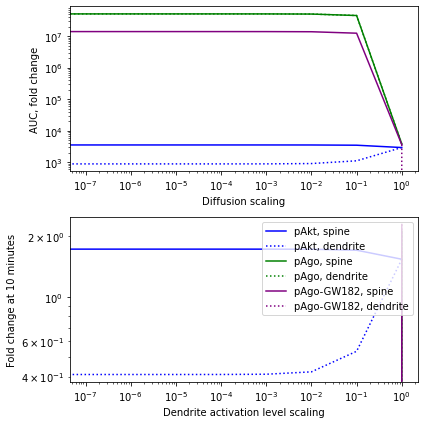

In [60]:
fig, ax = plt.subplots(2, figsize = (6, 6))

ax[0].plot(scaling,
           aucs['spR'],
           color = 'blue',
           linestyle = '-')
ax[0].plot(scaling,
           aucs['dpR'],
           color = 'blue',
           linestyle = ':')
ax[0].plot(scaling,
           aucs['spA'],
           color = 'green',
           linestyle = '-')
ax[0].plot(scaling,
           aucs['spA'],
           color = 'green',
           linestyle = ':')
ax[0].plot(scaling,
           aucs['spAG'],
           color = 'purple',
           linestyle = '-')
ax[0].plot(scaling,
           aucs['dpAG'],
           color = 'purple',
           linestyle = ':')

ax[0].set_ylabel('AUC, fold change')
ax[0].set_xlabel('Diffusion scaling')
ax[0].set_yscale('log')
ax[0].set_xscale('log')

ax[1].plot(scaling,
           tenMin['spR'],
           color = 'blue',
           linestyle = '-')
ax[1].plot(scaling,
           tenMin['dpR'],
           color = 'blue',
           linestyle = ':')
ax[1].plot(scaling,
           tenMin['spA'],
           color = 'green',
           linestyle = '-')
ax[1].plot(scaling,
           tenMin['spA'],
           color = 'green',
           linestyle = ':')
ax[1].plot(scaling,
           tenMin['spAG'],
           color = 'purple',
           linestyle = '-')
ax[1].plot(scaling,
           tenMin['dpAG'],
           color = 'purple',
           linestyle = ':')

ax[1].set_ylabel('Fold change at 10 minutes')
ax[1].set_xlabel('Dendrite activation level scaling')
ax[1].set_yscale('log')
ax[1].set_xscale('log')

l2 = mlines.Line2D([], [], linestyle = '-', color = 'blue', label = 'pAkt, spine')
l2d = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt, dendrite')
l4 = mlines.Line2D([], [], linestyle = '-', color = 'green', label = 'pAgo, spine')
l4d = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'pAgo, dendrite')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'purple', label = 'pAgo-GW182, spine')
l5d = mlines.Line2D([], [], linestyle = ':', color = 'purple', label = 'pAgo-GW182, dendrite')

ls = [l2, l2d, l4, l4d, l5, l5d]



plt.legend(handles = ls, loc = 1)


plt.tight_layout()

plt.savefig(r'./plots/diffusion_scaling-vs-fold_change_cd.svg', dpi = 600, bbox_inches = 'tight')

plt.show()